After installing it, now we will load the dataset, keeping the 80% and 20% split for training and validation respectively. 

In [1]:
# loading the dataset
import tensorflow_datasets as tfds
import tensorflow as tf
(train_examples, validation_examples), info = tfds.load(
   'cats_vs_dogs',
   split = ('train[:80%]', 'train[80%:]'),
   with_info = True,
   as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteWGKIL0/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


# **Preprocessing the images**




Here in this step we will create a shuffled version of the above images and will resize all images to 224 x 244 x 3 pixels

In [10]:
# function to resize images
def format_image(image, label):
 image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
 return image,label

# examples available
num_examples = info.splits['train'].num_examples

# set the batch size and image size
BATCH_SIZE = 32
IMAGE_RES = 150

# Creating the suffled batches
train_batches = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

<Figure size 720x360 with 0 Axes>

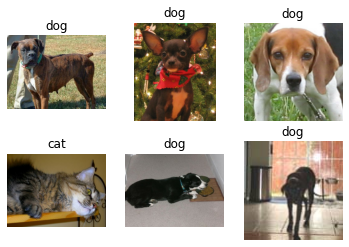

In [11]:
# take look at some samples
import matplotlib.pyplot as plt
classNames = ['cat', 'dog']
i = 0
plt.figure(figsize=(10,5))
fig, ax = plt.subplots(1, 8)
for image, label in train_examples.take(6):
 plt.subplot(2,3,i+1)
 plt.axis('off')
 plt.title(classNames[label])
 plt.imshow(image)
 i += 1
plt.show()

# **Step 3: Building the model**

Here in this step, we will be building the convolution-based classifier model. Our model will have 3 convolutional and max-pooling layers and two dense layers. Except for the last layer, the neurons of the rest of the layers fire according to the ReLU activation function. The last layer is a classifier layer; the neurons will be fired according to the soft function. 

In [12]:
# Model building 
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

So there are a total of 9,494,561 parameters to be trained on all 5 trainable layers. 

# **Step 4: Creating train and test data generator**

Now we will create a generator function which will help us to pass the data batch-wise while training and testing. Although with these generators we can perform certain preprocessing steps such as scaling down the pixel values, augmenting the data, changing the shape of images, etc. 

So below we will create such two sets one for training purposes and the other for validation purposes

In [ ]:
# Creating the separate training and testing set
from tensorflow.keras.preprocessing.image import ImageDataGenerator
TRAINING_DIR = "cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                 batch_size=250,
                                                 class_mode='binary',
                                                 target_size=(150, 150))
VALIDATION_DIR = "cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                           batch_size=250,
                                                           class_mode='binary',
                                                           target_size=(150, 150))

In [ ]:
# Assigned target classes
Validation_generator.class_indices

# **Train and evaluate the model**

In [15]:
# Training the model
# Note that this may take some time.
history = model.fit(train_batches, epochs=15,validation_data=validation_batches)

Epoch 1/15
582/582 [==============================] - 502s 849ms/step - loss: 0.6609 - acc: 0.6530 - val_loss: 0.5364 - val_acc: 0.7307
Epoch 2/15
582/582 [==============================] - 468s 803ms/step - loss: 0.5116 - acc: 0.7480 - val_loss: 0.4549 - val_acc: 0.7837
Epoch 3/15
582/582 [==============================] - 459s 788ms/step - loss: 0.4420 - acc: 0.7953 - val_loss: 0.4684 - val_acc: 0.7831
Epoch 4/15
582/582 [==============================] - 463s 795ms/step - loss: 0.3917 - acc: 0.8259 - val_loss: 0.4912 - val_acc: 0.7786
Epoch 5/15
582/582 [==============================] - 462s 793ms/step - loss: 0.3483 - acc: 0.8516 - val_loss: 0.5126 - val_acc: 0.7771
Epoch 6/15
582/582 [==============================] - 465s 799ms/step - loss: 0.2995 - acc: 0.8760 - val_loss: 0.4831 - val_acc: 0.7885
Epoch 7/15
582/582 [==============================] - 463s 796ms/step - loss: 0.2541 - acc: 0.8984 - val_loss: 0.6123 - val_acc: 0.8151
Epoch 8/15
582/582 [============================

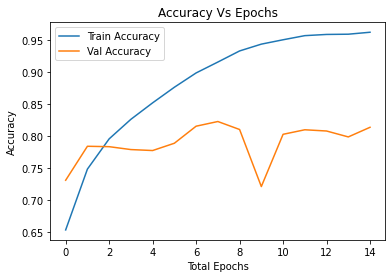

In [16]:
# Accuracy and Loss plot
plt.plot(history.history['acc'], label = 'Train Accuracy')
plt.plot(history.history['val_acc'], label = 'Val Accuracy')
plt.xlabel('Total Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()

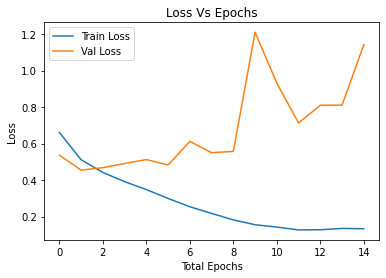

In [17]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Total Epochs')
plt.ylabel('Loss')
plt.title('Loss Vs Epochs')
plt.legend()

# **Predicting the random image**

In [18]:
import requests 
import numpy as np
import cv2

In [19]:
def pred(url):
  req = requests.get(url)
  arr = np.asarray(bytearray(req.content), dtype=np.uint8)
  img = cv2.imdecode(arr, -1) 
  plt.imshow(img)
  plt.axis('off')
  test = cv2.resize(img,(150,150))
  result = model.predict(test.reshape(1,150, 150, 3)/255.)
  return "The given image is of {}".format('cat' if result.round()==1 else 'dog')

'The given image is of dog'

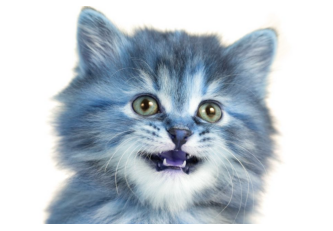

In [20]:
pred('https://moderncat.com/wp-content/uploads/2014/03/tortoiseshell-kitten-closeup-p-46771525-940x640.jpg')

'The given image is of dog'

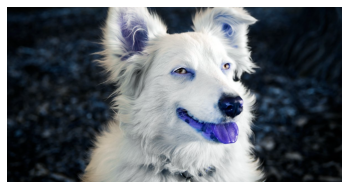

In [21]:
pred('https://api.time.com/wp-content/uploads/2017/04/world-of-dogs-07.jpg?quality=85&w=1200&h=628&crop=1')